<a href="https://colab.research.google.com/github/alexandre-pinon/zoidberg-2.0/blob/main/zoidberg_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<header align="center">
  <h1>* T-DEV *</h1>
  <h1>~ Zoidberg 2.0 ~</h1>
  <p>
    <i>Alexandre.P | Bryan.S | Camille.V | Liza.H | Théo.M</i>
  </p>
  <img src="https://media.istockphoto.com/photos/robot-with-education-hud-picture-id966248982?k=20&m=966248982&s=612x612&w=0&h=gq35V9G0kfjKu0ttr90c8p0VraNtqPDkTvqWQ8oXzCk=" alt="AI img"/>
  <h2>Given some X-ray images, use machine learning to help doctors detecting pneumonia.</h2>
</header>

# Notebook config

## Constants

In [1]:
BINARY_DATASET_DIR = "datasets/chest_Xray_binary"
MULTI_DATASET_DIR = "datasets/chest_Xray_multi"
SEED = 12
IMG_SIZE = 224, 224
BATCH_SIZE = 32
EPOCHS = 20

## Load data & helpers

In [2]:
# !git clone -b colab-data "https://github.com/alexandre-pinon/zoidberg-2.0.git"

In [3]:
# !wget https://raw.githubusercontent.com/alexandre-pinon/zoidberg-2.0/main/helpers.py

## Imports

In [2]:
import os
import pathlib
import random

import helpers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

from tensorflow.keras import Model, layers, optimizers, models, metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [12]:
import importlib
importlib.reload(helpers)

<module 'helpers' from '/home/nowaffle/epitech/zoidberg-2.0/helpers.py'>

# Data analysis

## Datasets distribution

In [7]:
helpers.walk_through_dir(BINARY_DATASET_DIR)

There are 3 directories and 0 images in 'datasets/chest_Xray_binary'.
There are 2 directories and 0 images in 'datasets/chest_Xray_binary/val'.
There are 0 directories and 8 images in 'datasets/chest_Xray_binary/val/pneumonia'.
There are 0 directories and 8 images in 'datasets/chest_Xray_binary/val/normal'.
There are 2 directories and 0 images in 'datasets/chest_Xray_binary/test'.
There are 0 directories and 390 images in 'datasets/chest_Xray_binary/test/pneumonia'.
There are 0 directories and 234 images in 'datasets/chest_Xray_binary/test/normal'.
There are 2 directories and 0 images in 'datasets/chest_Xray_binary/train'.
There are 0 directories and 3875 images in 'datasets/chest_Xray_binary/train/pneumonia'.
There are 0 directories and 1341 images in 'datasets/chest_Xray_binary/train/normal'.


In [8]:
helpers.walk_through_dir(MULTI_DATASET_DIR)

There are 3 directories and 0 images in 'datasets/chest_Xray_multi'.
There are 2 directories and 0 images in 'datasets/chest_Xray_multi/val'.
There are 0 directories and 8 images in 'datasets/chest_Xray_multi/val/normal'.
There are 0 directories and 8 images in 'datasets/chest_Xray_multi/val/bacteria'.
There are 3 directories and 0 images in 'datasets/chest_Xray_multi/test'.
There are 0 directories and 148 images in 'datasets/chest_Xray_multi/test/virus'.
There are 0 directories and 234 images in 'datasets/chest_Xray_multi/test/normal'.
There are 0 directories and 242 images in 'datasets/chest_Xray_multi/test/bacteria'.
There are 3 directories and 0 images in 'datasets/chest_Xray_multi/train'.
There are 0 directories and 1345 images in 'datasets/chest_Xray_multi/train/virus'.
There are 0 directories and 1341 images in 'datasets/chest_Xray_multi/train/normal'.
There are 0 directories and 2530 images in 'datasets/chest_Xray_multi/train/bacteria'.


As we can see, the datasets are **unbalanced**:
* There is almost 3 times as more pneumonia images than normal images in the binary dataset
* There is almost 2 times as more bacteria images than normal and virus images in the binary dataset

There is no virus image in both val directories so we'll use it as a small graphical test dataset for **binary** classification only.

We need to **split** the train set to make our own validation set.

In [4]:
binary_train_dir = f"{BINARY_DATASET_DIR}/train/"
multi_train_dir = f"{MULTI_DATASET_DIR}/train/"
val_dir = f"{BINARY_DATASET_DIR}/val/"
binary_test_dir = f"{BINARY_DATASET_DIR}/test/"
multi_test_dir = f"{MULTI_DATASET_DIR}/test/"

In [5]:
binary_class_names = sorted(os.listdir(binary_train_dir))
multi_class_names = sorted(os.listdir(multi_train_dir))

In [6]:
normal_train_img_count = len(os.listdir(f"{binary_train_dir}normal"))
pneumonia_train_img_count = len(os.listdir(f"{binary_train_dir}pneumonia"))
bacteria_train_img_count = len(os.listdir(f"{multi_train_dir}bacteria"))
virus_train_img_count = len(os.listdir(f"{multi_train_dir}virus"))

total_train_img_count = normal_train_img_count + pneumonia_train_img_count
assert (total_train_img_count == normal_train_img_count +
        bacteria_train_img_count + virus_train_img_count)


## Datasets visualization

Let's take a look at a few images of the train sets

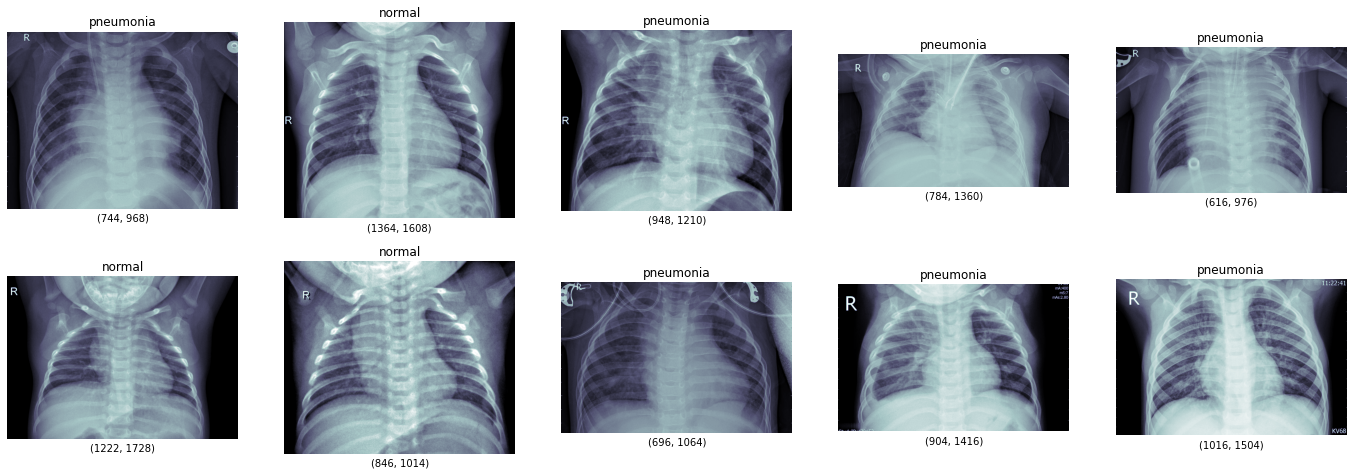

In [13]:
helpers.view_random_images(binary_train_dir, binary_class_names)

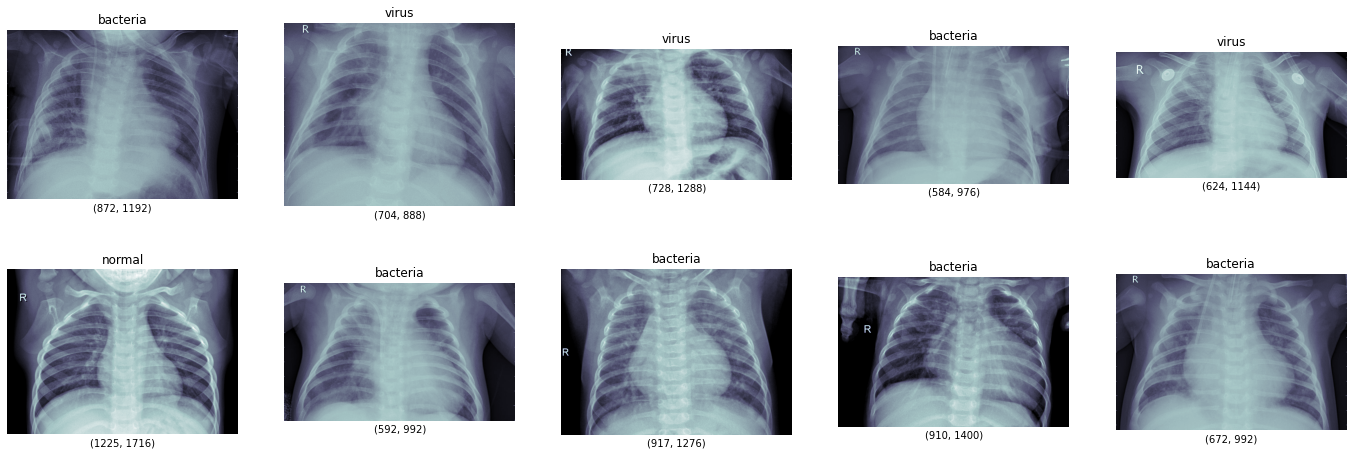

In [14]:
helpers.view_random_images(multi_train_dir, multi_class_names)

# Preprocessing

We'll start simple by normalizing our data

In [9]:
train_datagen = ImageDataGenerator(rescale=1 / 255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1 / 255.)

In [10]:
binary_train_data = train_datagen.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='training')

binary_val_data = train_datagen.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='validation')

binary_test_data = test_datagen.flow_from_directory(
    directory=binary_test_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [18]:
multi_train_data = train_datagen.flow_from_directory(
    directory=multi_train_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='training')

multi_val_data = train_datagen.flow_from_directory(
    directory=multi_train_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='validation')

multi_test_data = test_datagen.flow_from_directory(
    directory=multi_test_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED)

Found 4173 images belonging to 3 classes.
Found 1043 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


# Create models

## Fully connected dense models (baseline)

In [18]:
inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = layers.Flatten()(inputs)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_dense_model = Model(inputs=inputs,
                           outputs=outputs,
                           name="binary_dense_model")

outputs = layers.Dense(len(multi_class_names),
                       activation="softmax",
                       name="output_layer")(x)
multi_dense_model = Model(inputs=inputs,
                          outputs=outputs,
                          name="multi_dense_model")

2022-05-05 21:31:59.013533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-05 21:31:59.019317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-05 21:31:59.019617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-05-05 21:31:59.020241: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "binary_dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 100)               15052900  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,07

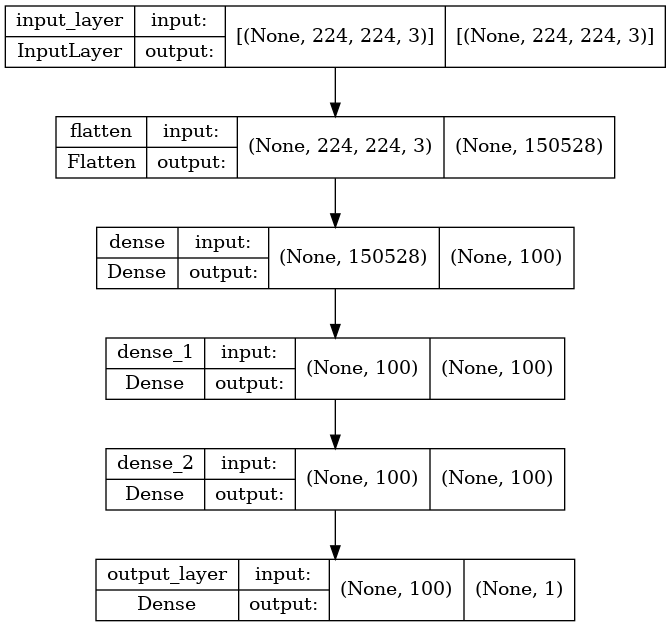

In [19]:
binary_dense_model.summary()
plot_model(binary_dense_model, show_shapes=True)

## Basic CNN: Tiny VGG

In [20]:
inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = layers.Conv2D(10, 3, activation='relu')(inputs)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_tiny_vgg = Model(inputs=inputs, outputs=outputs, name="binary_tiny_vgg")

outputs = layers.Dense(len(multi_class_names),
                       activation="softmax",
                       name="output_layer")(x)
multi_tiny_vgg = Model(inputs=inputs, outputs=outputs, name="multi_tiny_vgg")

Model: "binary_tiny_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                   

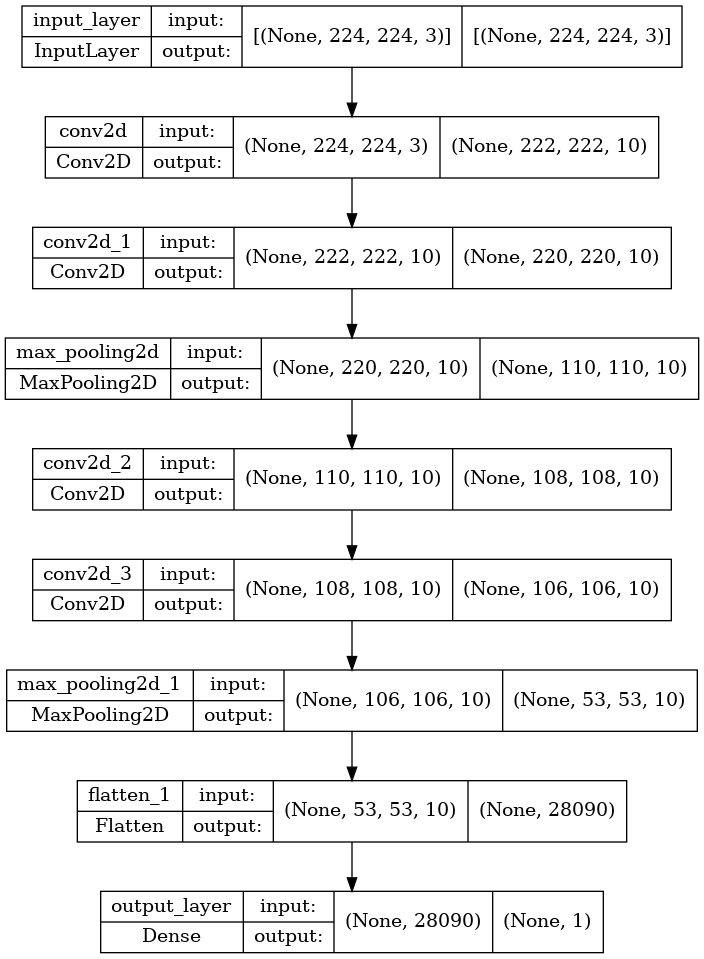

In [21]:
binary_tiny_vgg.summary()
plot_model(binary_tiny_vgg, show_shapes=True)

## Complex CNN: Densenet201

In [22]:
base_model = tf.keras.applications.DenseNet201(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_densenet_201 = Model(inputs=inputs,
                            outputs=outputs,
                            name="binary_densenet_201")

outputs = layers.Dense(len(multi_class_names),
                       activation="softmax",
                       name="output_layer")(x)
multi_densenet_201 = Model(inputs=inputs,
                           outputs=outputs,
                           name="multi_densenet_201")

Model: "binary_densenet_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 global_average_pooling_laye  (None, 1920)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


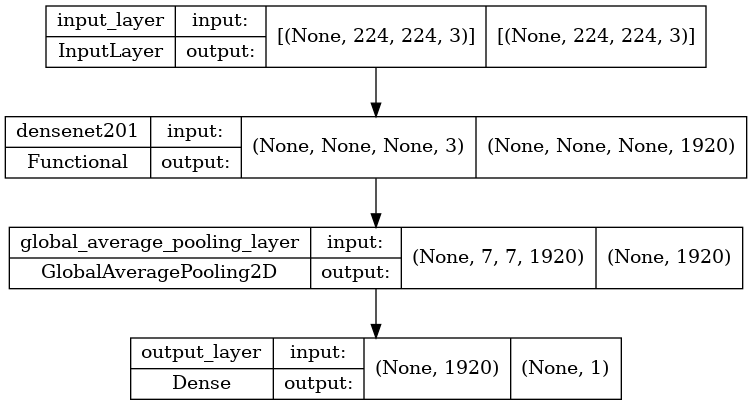

In [23]:
binary_densenet_201.summary()
plot_model(binary_densenet_201, show_shapes=True, )

In [28]:
# base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                     

# Train models

## Model compilations

In [31]:
binary_models = [binary_dense_model, binary_tiny_vgg, binary_densenet_201]
multi_models = [multi_dense_model, multi_tiny_vgg, multi_densenet_201]

for binary_model in binary_models:
    binary_model.compile(loss='binary_crossentropy',
                         optimizer=optimizers.Adam(),
                         metrics=['accuracy', 'Precision', 'Recall'])

for multi_model in multi_models:
    multi_model.compile(loss='categorical_crossentropy',
                        optimizer=optimizers.Adam(),
                        metrics=['accuracy', 'Precision', 'Recall'])

## Model trainings

In [32]:
tf.random.set_seed(SEED)

binary_histories = [
    binary_model.fit(binary_train_data,
                     epochs=EPOCHS,
                     validation_data=binary_val_data,
                     verbose=False) for binary_model in binary_models
]

multi_histories = [
    multi_model.fit(multi_train_data,
                    epochs=EPOCHS,
                    validation_data=multi_val_data,
                    verbose=False) for multi_model in multi_models
]

2022-05-05 21:51:18.255011: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-05 21:51:19.664856: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-05 21:51:19.673435: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-05-05 21:58:58.825043: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-05 21:58:58.825107: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator 

## Model saving

In [34]:
for binary_model in binary_models:
    binary_model.save(f'binary_models/{binary_model._name}')
for multi_model in multi_models:
    multi_model.save(f'multi_models/{multi_model._name}')

INFO:tensorflow:Assets written to: binary_models/binary_dense_model/assets
INFO:tensorflow:Assets written to: binary_models/binary_tiny_vgg/assets
INFO:tensorflow:Assets written to: binary_models/binary_densenet_201/assets
INFO:tensorflow:Assets written to: multi_models/multi_dense_model/assets
INFO:tensorflow:Assets written to: multi_models/multi_tiny_vgg/assets
INFO:tensorflow:Assets written to: multi_models/multi_densenet_201/assets


In [ ]:
# !cp binary_models drive/MyDrive/tf_saved_models
# !cp multi_models drive/MyDrive/tf_saved_models

# Evaluate models (no preprocessing)

## Metrics computation

In [19]:
binary_evaluation_scores = [
    helpers.evaluate_model_binary(binary_model, binary_test_data)
    for binary_model in binary_models
]

multi_evaluation_scores = [
    helpers.evaluate_model_multi(multi_model, multi_test_data)
    for multi_model in multi_models
]

In [20]:
binary_metrics = [score[2] for score in binary_evaluation_scores]
multi_metrics = [score[2] for score in multi_evaluation_scores]

In [37]:
binary_scores_df = pd.DataFrame(binary_metrics)
binary_scores_df['model'] = [m.name for m in binary_models]
binary_scores_df.set_index('model', inplace=True)
binary_scores_df.applymap('{:.2%}'.format)

,accuracy,precision,recall,f1
model,,,,
binary_dense_model,23.08%,5.00%,1.28%,2.04%
binary_tiny_vgg,79.33%,77.59%,94.10%,85.05%
binary_densenet_201,78.37%,74.47%,99.49%,85.18%


In [38]:
multi_scores_df = pd.DataFrame(multi_metrics)
multi_scores_df['model'] = [m.name for m in multi_models]
multi_scores_df.set_index('model', inplace=True)
multi_scores_df.applymap('{:.2%}'.format)

,accuracy,precision,recall,f1
model,,,,
multi_dense_model,50.80%,54.57%,50.80%,42.66%
multi_tiny_vgg,61.86%,70.13%,61.86%,60.13%
multi_densenet_201,75.48%,80.99%,75.48%,74.95%


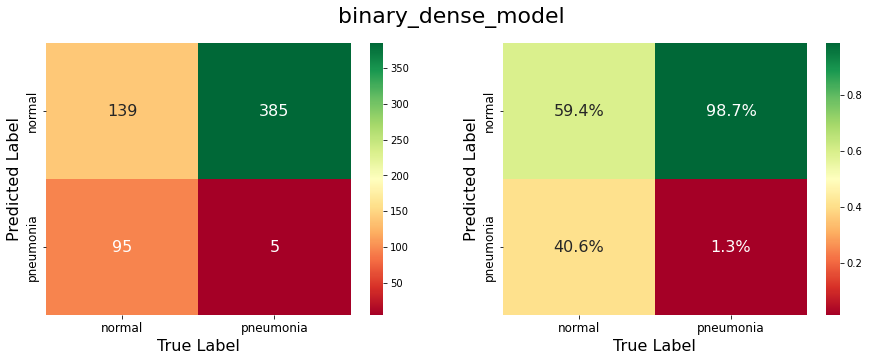

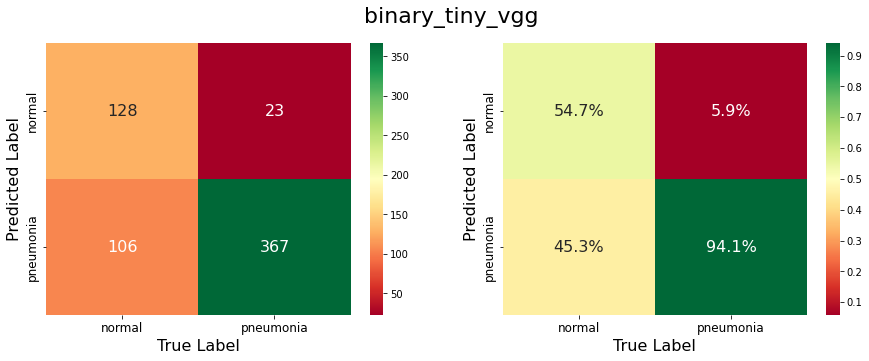

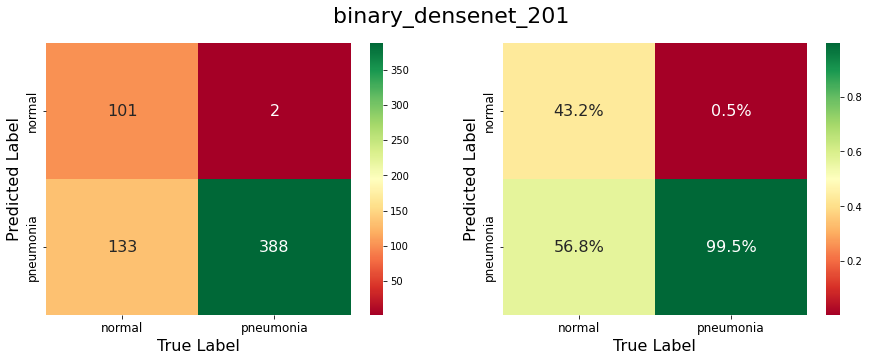

In [45]:
for i, (y_true, y_pred, _) in enumerate(binary_evaluation_scores):
  cm = confusion_matrix(y_true, y_pred)
  helpers.plot_confusion_matrixes(cm.T, binary_class_names, model_name=binary_models[i].name)

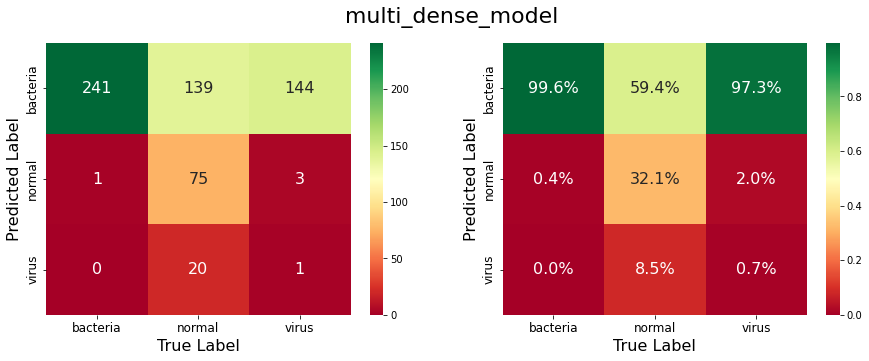

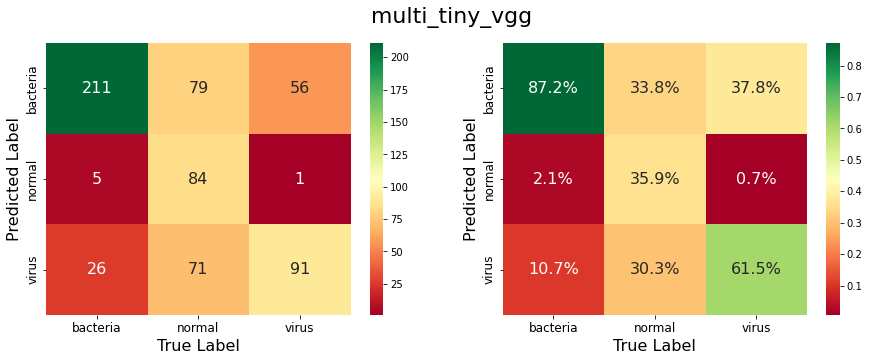

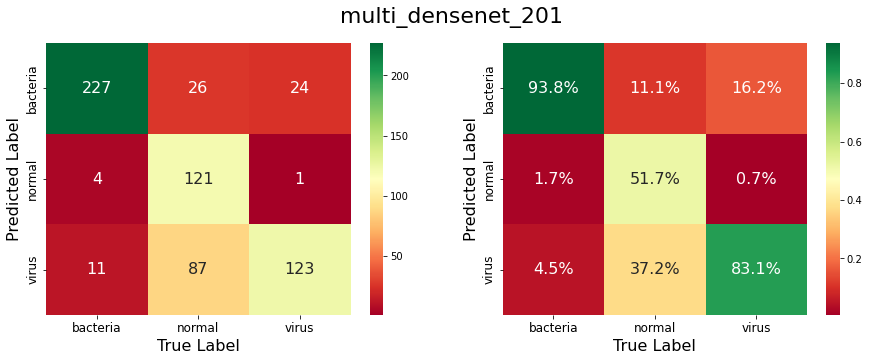

In [47]:
for i, (y_true, y_pred, _) in enumerate(multi_evaluation_scores):
  cm = confusion_matrix(y_true, y_pred)
  helpers.plot_confusion_matrixes(cm.T, multi_class_names, model_name=multi_models[i].name)

As we can see, the densenet model is the one with the most potential : without any optimization it outperforms both other model on the multi label dataset and is almost as good as the tiny vgg for the binary classification.

# Optimize model

For now let's try to optimize our best model on binary classification

## Data augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=20,  # rotate the image slightly between 0 and 20 degrees
    shear_range=0.2,  # shear the image
    zoom_range=0.2,  # zoom into the image
    width_shift_range=0.2,  # shift the image width ways
    height_shift_range=0.2,  # shift the image height ways
    horizontal_flip=True,  # flip the image on the horizontal axis
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1 / 255.)

In [8]:
binary_train_data = train_datagen.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='training')

binary_val_data = train_datagen.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='validation')

binary_test_data = test_datagen.flow_from_directory(
    directory=binary_test_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Model copy & training

Let's rebuild a clone of our best model so far
> 🔑 **Note**: We can't really use `tf.keras.models.clone_model` here because we need to copy the weights of the pre-**trained** densenet 201 model and not the one we just trained nor take random weights 

In [30]:
def train_new_densenet201_model(train_data,
                                val_data,
                                seed=2,
                                name=None,
                                fine_tune_model=False,
                                img_size=(224, 224),
                                epochs=20,
                                class_weight=None,
                                verbose=False):
    """
    Creates a new densenet201 model with given parameters and train it.
    Returns the trained model and the training history
    """
    tf.random.set_seed(seed)

    # Model creation
    base_model = tf.keras.applications.DenseNet201(include_top=False)
    if not fine_tune_model:
        base_model.trainable = False
        learning_rate = 1e-3
    else:
        base_model.trainable = True
        learning_rate = 1e-4
        # Unfreeze the 20 last layers
        for layer in base_model.layers[:-20]:
            layer.trainable = False

    inputs = layers.Input(shape=(*img_size, 3), name="input_layer")
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

    outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
    model = Model(inputs=inputs, outputs=outputs, name=name)

    # Model compilation
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy', 'Precision', 'Recall'])

    # Model training
    history = model.fit(train_data,
                        epochs=epochs,
                        validation_data=val_data,
                        class_weight=class_weight,
                        verbose=verbose)

    return model, history


In [10]:
binary_densenet_201_v2, history = train_new_densenet201_model(
    binary_train_data,
    binary_val_data,
    seed=SEED,
    name='binary_densenet_201_v2',
    img_size=IMG_SIZE,
    epochs=EPOCHS)


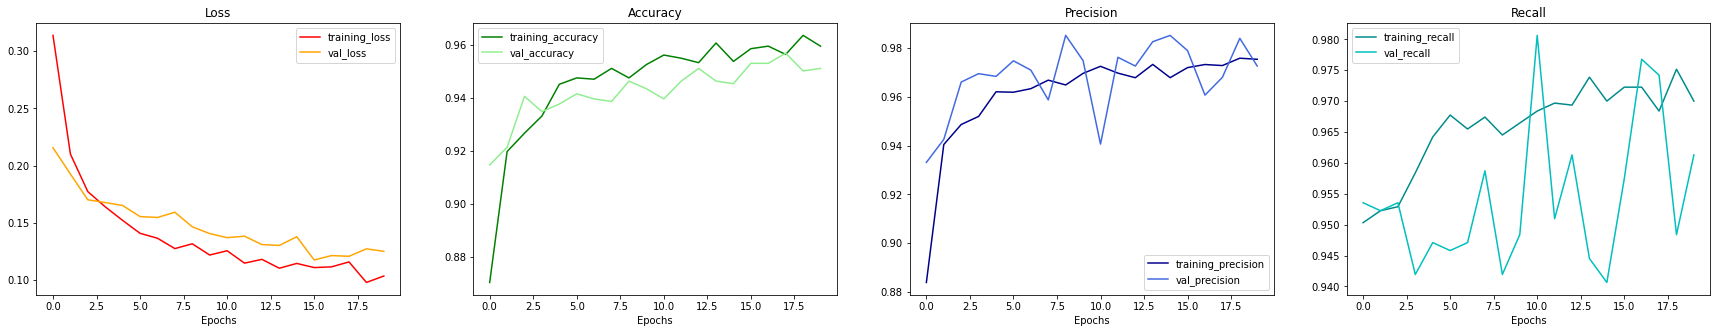

In [13]:
helpers.plot_loss_curves(history)

### Model saving

In [14]:
binary_densenet_201_v2.save(f'binary_models/{binary_densenet_201_v2.name}')

2022-05-10 20:26:35.495678: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: binary_models/binary_densenet_201_v2/assets


In [21]:
binary_densenet_201 = models.load_model('binary_models/binary_densenet_201')
binary_densenet_201_v2 = models.load_model('binary_models/binary_densenet_201_v2')

### Model evaluation

In [21]:
def compare_models(models, test_data, type='binary'):
    if type == 'binary':
        evaluation_scores = [
            helpers.evaluate_model_binary(model, test_data) for model in models
        ]
    elif type == 'multi':
        evaluation_scores = [
            helpers.evaluate_model_multi(model, test_data) for model in models
        ]
    
    metrics = [score[2] for score in evaluation_scores]

    df = pd.DataFrame(metrics)
    df['model'] = [m.name for m in models]
    df.set_index('model', inplace=True)
    
    return evaluation_scores, df.applymap('{:.2%}'.format)


In [46]:
binary_models = [binary_densenet_201, binary_densenet_201_v2]
binary_evaluation_scores, df = compare_models(binary_models, binary_test_data)
df

,accuracy,precision,recall,f1
model,,,,
binary_densenet_201,78.37%,74.47%,99.49%,85.18%
binary_densenet_201_v2,89.42%,89.32%,94.36%,91.77%


As we can see, data augmentation greatly helped reduce overfitting, thus improving our model's overall performance

Let's see how our confusion matrixes look like:

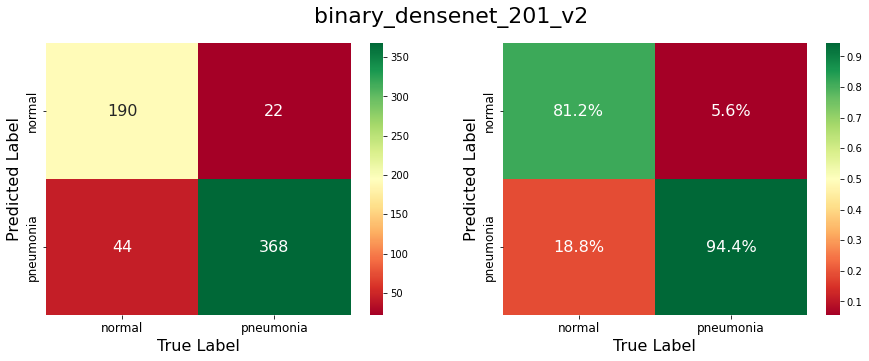

In [47]:
y_true, y_pred, _ = binary_evaluation_scores[-1]
cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names, model_name=binary_models[-1].name)

## Class balancing

It seems that our model still struggle to predict `normal` images
This could be explained by the fact that our training dataset in **unbalanced**:

In [30]:
print(
    f'In our training dataset, we have {normal_train_img_count} "normal" images and {pneumonia_train_img_count} "pneumonia" images for a total of {total_train_img_count} images'
)
print(
    f'This means that we have around {pneumonia_train_img_count/normal_train_img_count:.1f} times more "pneumonia" images'
)


In our training dataset, we have 1341 "normal" images and 3875 "pneumonia" images for a total of 5216 images
This means that we have around 2.9 times more "pneumonia" images


There are several different approaches to correct an unbalance dataset
- **Under-sampling**: balances the dataset by reducing the size of the abundant class
- **Over-sampling**: balance dataset by increasing the size of rare samples
- **Class weights calculation**: heavier weights are applied to the minority classes, indicating the model must give more importance to these classes

In [15]:
normal_ratio = normal_train_img_count / total_train_img_count
normal_weight = 1 / (len(binary_class_names) * normal_ratio)
pneumonia_ratio = pneumonia_train_img_count / total_train_img_count
pneumonia_weight = 1 / (len(binary_class_names) * pneumonia_ratio)

binary_class_weight = {0: normal_weight, 1: pneumonia_weight}

print(f'Weight for class {binary_class_names[0]}: {normal_weight:.2f}')
print(f'Weight for class {binary_class_names[1]}: {pneumonia_weight:.2f}')

Weight for class normal: 1.94
Weight for class pneumonia: 0.67


### Model copy & training

In [16]:
binary_densenet_201_v3, history = train_new_densenet201_model(
    binary_train_data,
    binary_val_data,
    seed=SEED,
    name='binary_densenet_201_v3',
    img_size=IMG_SIZE,
    epochs=EPOCHS,
    class_weight=binary_class_weight,
    verbose=True)

Epoch 1/20
131/131 [==============================] - 68s 472ms/step - loss: 0.3507 - accuracy: 0.8533 - precision: 0.9527 - recall: 0.8445 - val_loss: 0.3192 - val_accuracy: 0.8667 - val_precision: 0.9984 - val_recall: 0.8219
Epoch 2/20
131/131 [==============================] - 58s 440ms/step - loss: 0.2207 - accuracy: 0.9065 - precision: 0.9778 - recall: 0.8945 - val_loss: 0.2573 - val_accuracy: 0.8945 - val_precision: 0.9883 - val_recall: 0.8684
Epoch 3/20
131/131 [==============================] - 56s 429ms/step - loss: 0.1964 - accuracy: 0.9219 - precision: 0.9816 - recall: 0.9119 - val_loss: 0.2445 - val_accuracy: 0.9003 - val_precision: 0.9884 - val_recall: 0.8761
Epoch 4/20
131/131 [==============================] - 56s 424ms/step - loss: 0.1882 - accuracy: 0.9240 - precision: 0.9803 - recall: 0.9161 - val_loss: 0.2236 - val_accuracy: 0.9118 - val_precision: 0.9928 - val_recall: 0.8877
Epoch 5/20
131/131 [==============================] - 55s 422ms/step - loss: 0.1716 - accura

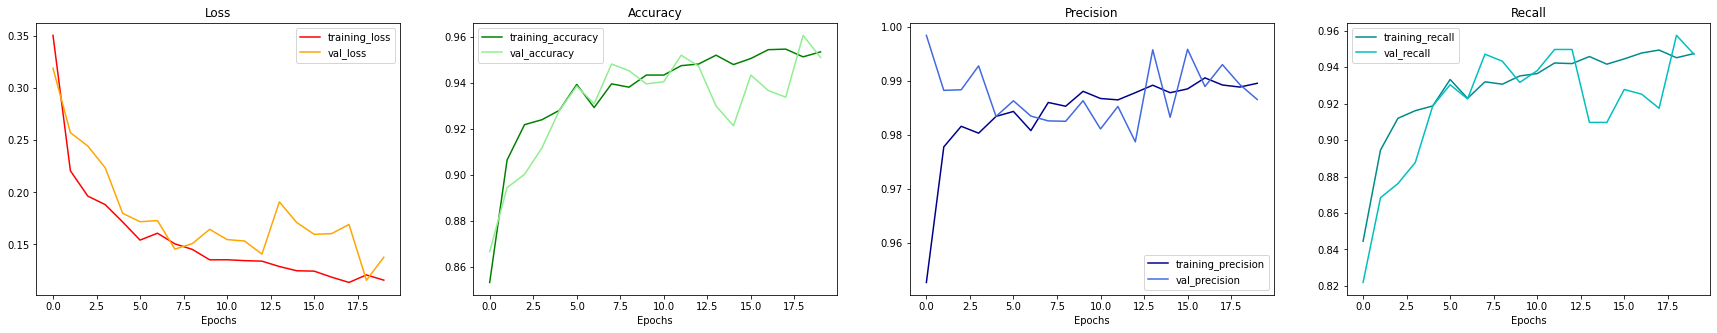

In [17]:
helpers.plot_loss_curves(history)

### Model saving

In [18]:
binary_densenet_201_v3.save(f'binary_models/{binary_densenet_201_v3.name}')

INFO:tensorflow:Assets written to: binary_models/binary_densenet_201_v3/assets


In [19]:
binary_densenet_201 = models.load_model('binary_models/binary_densenet_201')
binary_densenet_201_v2 = models.load_model('binary_models/binary_densenet_201_v2')
binary_densenet_201_v3 = models.load_model('binary_models/binary_densenet_201_v3')

### Model evaluation

In [22]:
binary_models = [binary_densenet_201, binary_densenet_201_v2, binary_densenet_201_v3]
binary_evaluation_scores, df = compare_models(binary_models, binary_test_data)
df

2022-05-10 21:25:01.453618: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-10 21:25:01.453684: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


,accuracy,precision,recall,f1
model,,,,
binary_densenet_201,78.37%,74.47%,99.49%,85.18%
binary_densenet_201_v2,90.06%,88.86%,96.15%,92.36%
binary_densenet_201_v3,90.54%,90.66%,94.62%,92.60%


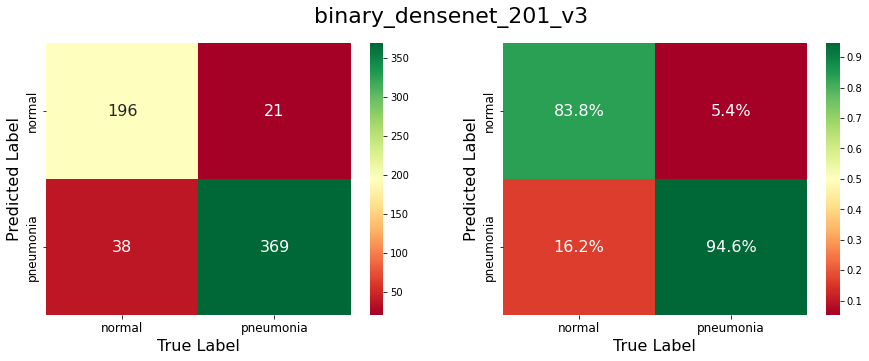

In [23]:
y_true, y_pred, _ = binary_evaluation_scores[-1]
cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names, model_name=binary_models[-1].name)

## Fine tuning

With the combination of data augmentation and class balancing, we were able to reach 90% on every metrics!

Let's try to optimize our model's performance with one last method: unfreeze its weights (which is also called fine tuning)

### Model copy & training

In [31]:
binary_densenet_201_v4, history = train_new_densenet201_model(
    binary_train_data,
    binary_val_data,
    seed=SEED,
    name='binary_densenet_201_v4',
    fine_tune_model=True,
    img_size=IMG_SIZE,
    epochs=EPOCHS,
    class_weight=binary_class_weight)

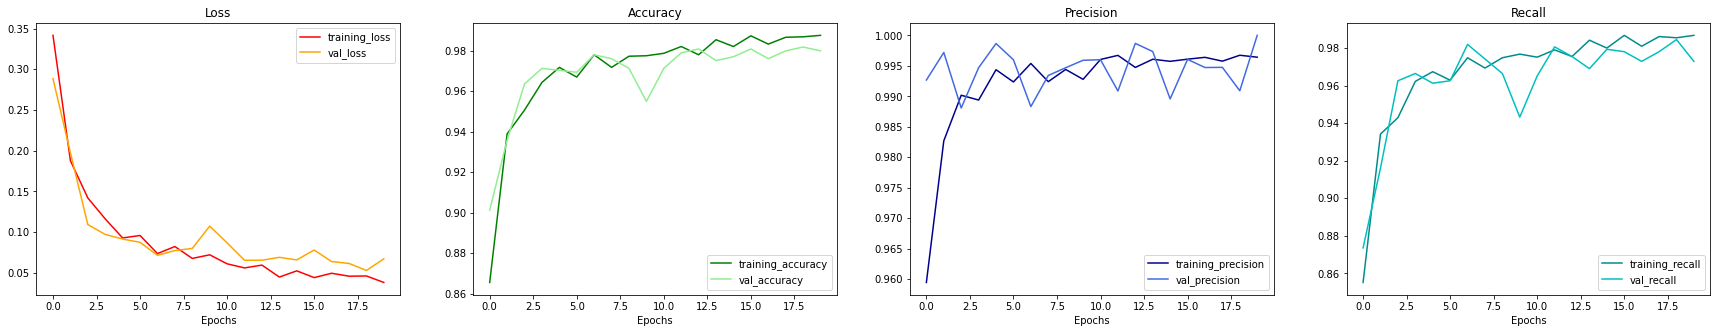

In [32]:
helpers.plot_loss_curves(history)

### Model saving

In [33]:
binary_densenet_201_v4.save(f'binary_models/{binary_densenet_201_v4.name}')

INFO:tensorflow:Assets written to: binary_models/binary_densenet_201_v4/assets


In [34]:
binary_densenet_201 = models.load_model('binary_models/binary_densenet_201')
binary_densenet_201_v2 = models.load_model('binary_models/binary_densenet_201_v2')
binary_densenet_201_v3 = models.load_model('binary_models/binary_densenet_201_v3')
binary_densenet_201_v4 = models.load_model('binary_models/binary_densenet_201_v4')

### Model evaluation

In [35]:
binary_models = [binary_densenet_201, binary_densenet_201_v2, binary_densenet_201_v3, binary_densenet_201_v4]
binary_evaluation_scores, df = compare_models(binary_models, binary_test_data)
df

,accuracy,precision,recall,f1
model,,,,
binary_densenet_201,78.37%,74.47%,99.49%,85.18%
binary_densenet_201_v2,90.06%,88.86%,96.15%,92.36%
binary_densenet_201_v3,90.54%,90.66%,94.62%,92.60%
binary_densenet_201_v4,94.39%,93.19%,98.21%,95.63%


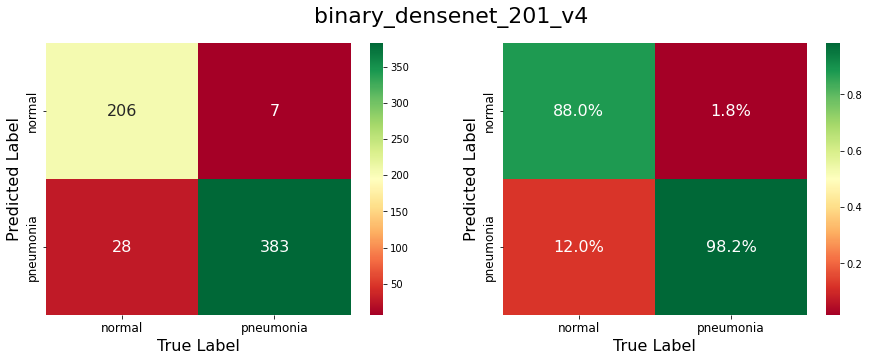

In [36]:
y_true, y_pred, _ = binary_evaluation_scores[-1]
cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names, model_name=binary_models[-1].name)

## Push to limit

It seems that our last models still slightly improving after 20 epochs: let's try to push its training to the limit!

In [ ]:
binary_densenet_201_v5, history = train_new_densenet201_model(
    binary_train_data,
    binary_val_data,
    seed=SEED,
    name='binary_densenet_201_v5',
    fine_tune_model=True,
    img_size=IMG_SIZE,
    epochs=5*EPOCHS,
    class_weight=binary_class_weight)

# TMP

In [ ]:
multi_class_names

['bacteria', 'normal', 'virus']

In [ ]:
weight_for_bacteria = (total_train_img_count /
                       bacteria_train_img_count) * (1 / len(multi_class_names))
weight_for_normal = (total_train_img_count /
                     normal_train_img_count) * (1 / len(multi_class_names))
weight_for_virus = (total_train_img_count /
                    virus_train_img_count) * (1 / len(multi_class_names))

class_weight = {
    0: weight_for_bacteria,
    1: weight_for_normal,
    2: weight_for_virus
}

print(f'Weight for class 0: {weight_for_bacteria:.2f}')
print(f'Weight for class 1: {weight_for_normal:.2f}')
print(f'Weight for class 2: {weight_for_virus:.2f}')

Weight for class 0: 0.69
Weight for class 1: 1.30
Weight for class 2: 1.29


In [ ]:
train_data_10_percent = multi_train_data_augmented.take(
    np.round(0.1 * multi_train_data.cardinality().numpy()))
val_data_10_percent = multi_val_data_augmented.take(
    np.round(0.1 * multi_val_data.cardinality().numpy()))


In [ ]:
multi_densenet_169_augmented = models.clone_model(multi_densenet_169)
multi_densenet_169_augmented.set_weights(multi_densenet_169.get_weights())

In [ ]:
multi_densenet_169_augmented.compile(loss='categorical_crossentropy',
                                     optimizer=optimizers.Adam(),
                                     metrics=["accuracy"])

In [ ]:
history = multi_densenet_169_augmented.fit(
    multi_train_data_augmented,
    epochs=EPOCHS,
    validation_data=multi_val_data_augmented,
    class_weight=class_weight)


Epoch 1/10
131/131 [==============================] - 148s 978ms/step - loss: 0.8034 - accuracy: 0.6252 - val_loss: 0.6843 - val_accuracy: 0.7047
Epoch 2/10
131/131 [==============================] - 113s 811ms/step - loss: 0.6630 - accuracy: 0.6863 - val_loss: 0.6568 - val_accuracy: 0.7172
Epoch 3/10
131/131 [==============================] - 113s 813ms/step - loss: 0.6314 - accuracy: 0.6990 - val_loss: 0.6045 - val_accuracy: 0.7430
Epoch 4/10
131/131 [==============================] - 113s 808ms/step - loss: 0.6148 - accuracy: 0.7179 - val_loss: 0.6200 - val_accuracy: 0.7258
Epoch 5/10
131/131 [==============================] - 113s 808ms/step - loss: 0.5934 - accuracy: 0.7242 - val_loss: 0.6334 - val_accuracy: 0.7095
Epoch 6/10
131/131 [==============================] - 113s 806ms/step - loss: 0.5857 - accuracy: 0.7232 - val_loss: 0.6232 - val_accuracy: 0.7057
Epoch 7/10
131/131 [==============================] - 113s 808ms/step - loss: 0.5850 - accuracy: 0.7239 - val_loss: 0.5713 -

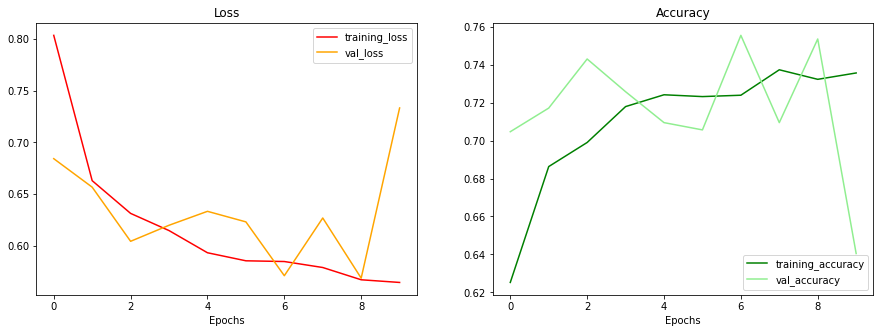

In [ ]:
helpers.plot_loss_curves(history)

In [ ]:
y_true, y_pred, metrics = helpers.evaluate_model_multi_batchdataset(
    multi_densenet_169_augmented, multi_test_data_augmented)
print(metrics)

{'accuracy': 0.7067307692307693, 'precision': 0.8004246617524859, 'recall': 0.7067307692307693, 'f1': 0.719800387881101}


In [ ]:
cm = confusion_matrix(y_true, y_pred)

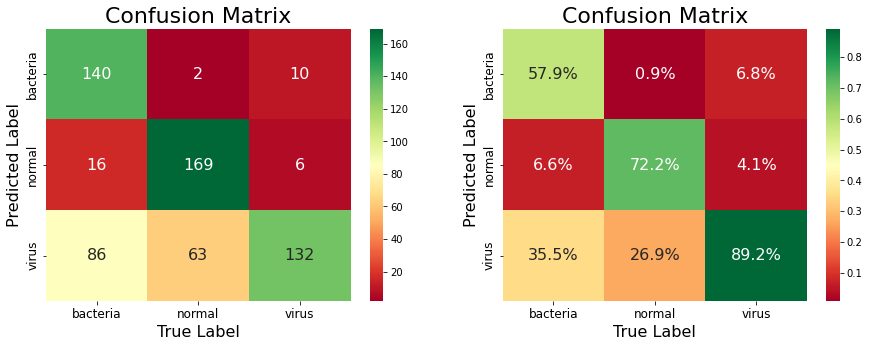

In [ ]:
helpers.plot_confusion_matrixes(cm.T, multi_class_names)

In [ ]:
binary_class_names

['normal', 'pneumonia']

## Binary weights

In [10]:
weight_for_normal = (total_train_img_count /
                     normal_train_img_count) * (1 / len(binary_class_names))
weight_for_pneumonia = (total_train_img_count / pneumonia_train_img_count) * (
    1 / len(binary_class_names))

binary_class_weight = {0: weight_for_normal, 1: weight_for_pneumonia}

print(f'Weight for class 0: {weight_for_normal:.2f}')
print(f'Weight for class 1: {weight_for_pneumonia:.2f}')

Weight for class 0: 1.94
Weight for class 1: 0.67


In [ ]:
binary_densenet_169_augmented = models.clone_model(binary_densenet_169)
binary_densenet_169_augmented.set_weights(binary_densenet_169.get_weights())

binary_densenet_169_augmented.compile(loss='binary_crossentropy',
                                      optimizer=optimizers.Adam(),
                                      metrics=["accuracy"])

history = binary_densenet_169_augmented.fit(
    binary_train_data_augmented,
    epochs=EPOCHS,
    validation_data=binary_val_data_augmented,
    class_weight=binary_class_weight)


Epoch 1/10
131/131 [==============================] - 153s 1s/step - loss: 0.4447 - accuracy: 0.7958 - val_loss: 0.2568 - val_accuracy: 0.9166
Epoch 2/10
131/131 [==============================] - 115s 814ms/step - loss: 0.2776 - accuracy: 0.8986 - val_loss: 0.3071 - val_accuracy: 0.8782
Epoch 3/10
131/131 [==============================] - 114s 812ms/step - loss: 0.2431 - accuracy: 0.9077 - val_loss: 0.2960 - val_accuracy: 0.8744
Epoch 4/10
131/131 [==============================] - 114s 813ms/step - loss: 0.2247 - accuracy: 0.9113 - val_loss: 0.2355 - val_accuracy: 0.9080
Epoch 5/10
131/131 [==============================] - 114s 816ms/step - loss: 0.2181 - accuracy: 0.9154 - val_loss: 0.2311 - val_accuracy: 0.9012
Epoch 6/10
131/131 [==============================] - 114s 813ms/step - loss: 0.2074 - accuracy: 0.9164 - val_loss: 0.2137 - val_accuracy: 0.9156
Epoch 7/10
131/131 [==============================] - 113s 808ms/step - loss: 0.2008 - accuracy: 0.9228 - val_loss: 0.2370 - va

{'accuracy': 0.8573717948717948, 'precision': 0.8443935926773455, 'recall': 0.9461538461538461, 'f1': 0.8923821039903265}


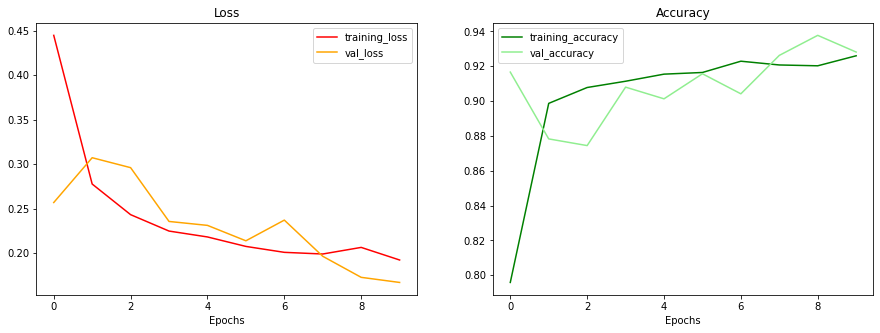

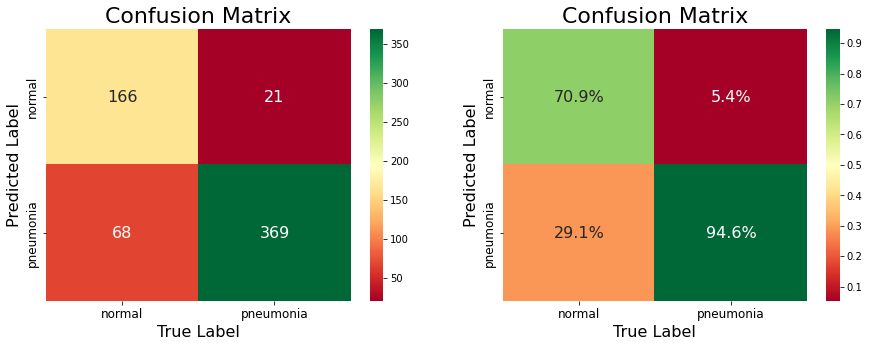

In [ ]:
helpers.plot_loss_curves(history)

y_true, y_pred, metrics = helpers.evaluate_model_binary_batchdataset(
    binary_densenet_169_augmented, binary_test_data_augmented)
print(metrics)

cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names)

In [ ]:
base_model = tf.keras.applications.DenseNet169(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_densenet_169 = Model(inputs=inputs,
                            outputs=outputs,
                            name="binary_densenet_169")

binary_densenet_169.compile(loss='binary_crossentropy',
                            optimizer=optimizers.Adam(learning_rate=0.0001),
                            metrics=["accuracy"])

binary_densenet_169.summary()

history = binary_densenet_169.fit(binary_train_data_augmented,
                                  epochs=2 * EPOCHS,
                                  validation_data=binary_val_data_augmented,
                                  class_weight=binary_class_weight)

51888128/51877672 [==============================] - 1s 0us/step
Model: "binary_densenet_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling_laye  (None, 1664)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 254,273
Non-trainable params: 12,390,272
_________________________________________________________________
Epoch 1/20
131/131 [==========

{'accuracy': 0.8878205128205128, 'precision': 0.868663594470046, 'recall': 0.9666666666666667, 'f1': 0.9150485436893204}


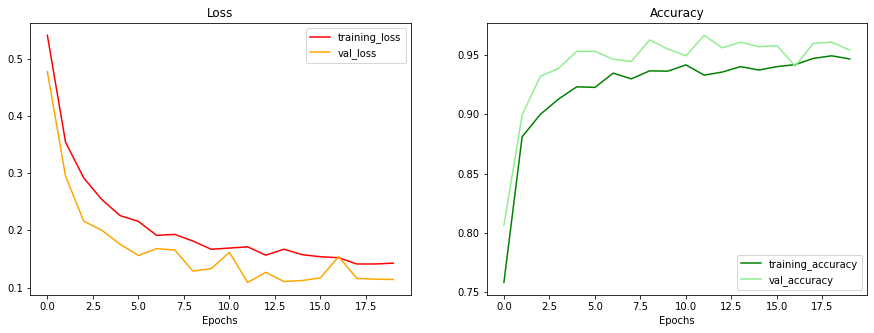

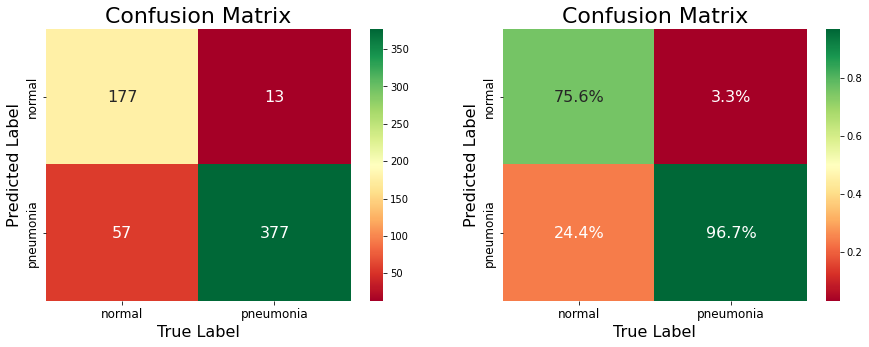

In [ ]:
helpers.plot_loss_curves(history)

y_true, y_pred, metrics = helpers.evaluate_model_binary_batchdataset(
    binary_densenet_169, binary_test_data_augmented)
print(metrics)

cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names)

## Current

In [12]:
base_model = tf.keras.applications.DenseNet169(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_densenet_169 = Model(inputs=inputs,
                            outputs=outputs,
                            name="binary_densenet_169")

binary_densenet_169.compile(loss='binary_crossentropy',
                            optimizer=optimizers.Adam(learning_rate=0.0001),
                            metrics=["accuracy"])

binary_densenet_169.summary()

history = binary_densenet_169.fit(binary_train_data_augmented,
                                  epochs=2 * EPOCHS,
                                  validation_data=binary_val_data_augmented,
                                  class_weight=binary_class_weight)

Model: "binary_densenet_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling_laye  (None, 1664)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 536,513
Non-trainable params: 12,108,032
_________________________________________________________________
Epoch 1/20


2022-05-02 20:35:37.722196: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-02 20:35:39.447322: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-02 20:35:39.455482: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


4173/4173 [==============================] - 196s 43ms/step - loss: 0.6005 - accuracy: 0.7239 - val_loss: 0.2989 - val_accuracy: 0.8945
Epoch 2/20
4173/4173 [==============================] - 177s 42ms/step - loss: 0.3642 - accuracy: 0.9092 - val_loss: 0.2890 - val_accuracy: 0.8936
Epoch 3/20
4173/4173 [==============================] - 177s 42ms/step - loss: 0.2412 - accuracy: 0.9279 - val_loss: 0.2538 - val_accuracy: 0.9080
Epoch 4/20
4173/4173 [==============================] - 185s 44ms/step - loss: 0.1914 - accuracy: 0.9370 - val_loss: 0.2405 - val_accuracy: 0.9166
Epoch 5/20


2022-05-02 20:47:52.804668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 802 of 1000


   1/4173 [..............................] - ETA: 16:02:26 - loss: 0.0292 - accuracy: 1.0000

2022-05-02 20:47:55.238963: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


4173/4173 [==============================] - 186s 41ms/step - loss: 0.1629 - accuracy: 0.9454 - val_loss: 0.1812 - val_accuracy: 0.9252
Epoch 6/20
4173/4173 [==============================] - 181s 43ms/step - loss: 0.1606 - accuracy: 0.9422 - val_loss: 0.1944 - val_accuracy: 0.9281
Epoch 7/20
4173/4173 [==============================] - 182s 42ms/step - loss: 0.1466 - accuracy: 0.9492 - val_loss: 0.1844 - val_accuracy: 0.9367
Epoch 8/20
4173/4173 [==============================] - 175s 42ms/step - loss: 0.1510 - accuracy: 0.9480 - val_loss: 0.1937 - val_accuracy: 0.9262
Epoch 9/20
4173/4173 [==============================] - 173s 40ms/step - loss: 0.1391 - accuracy: 0.9506 - val_loss: 0.2031 - val_accuracy: 0.9175
Epoch 10/20
4173/4173 [==============================] - 171s 41ms/step - loss: 0.1416 - accuracy: 0.9454 - val_loss: 0.2209 - val_accuracy: 0.9214
Epoch 11/20
4173/4173 [==============================] - 170s 41ms/step - loss: 0.1339 - accuracy: 0.9542 - val_loss: 0.2045 - v

{'accuracy': 0.8301282051282052, 'precision': 0.8047210300429185, 'recall': 0.9615384615384616, 'f1': 0.8761682242990655}


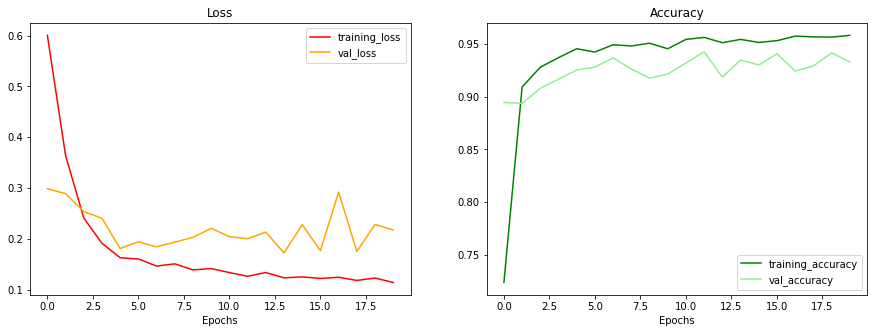

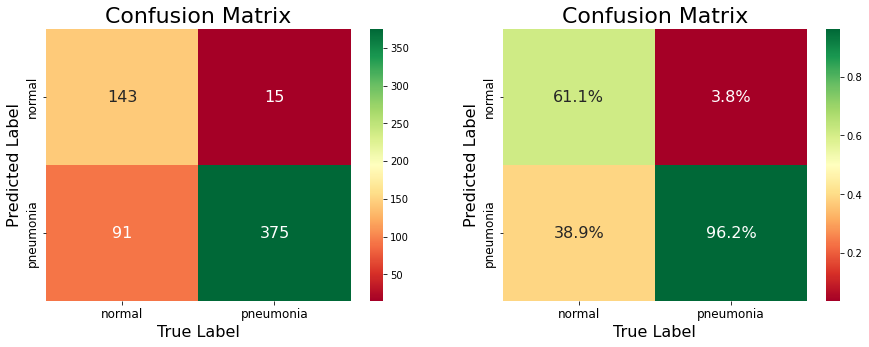

In [13]:
helpers.plot_loss_curves(history)

y_true, y_pred, metrics = helpers.evaluate_model_binary_batchdataset(
    binary_densenet_169, binary_test_data_augmented)
print(metrics)

cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names)

In [11]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=
    20,  # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
    shear_range=0.2,  # shear the image
    zoom_range=0.2,  # zoom into the image
    width_shift_range=0.2,  # shift the image width ways
    height_shift_range=0.2,  # shift the image height ways
    horizontal_flip=True,  # flip the image on the horizontal axis
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1 / 255.)

# Turn it into batches
train_data_augmented = train_datagen_augmented.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='training')

val_data_augmented = train_datagen_augmented.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='validation')

test_data = test_datagen.flow_from_directory(directory=binary_test_dir,
                                             target_size=IMG_SIZE,
                                             class_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             seed=SEED)

Found 5216 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
base_model = tf.keras.applications.DenseNet169(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_densenet_169 = Model(inputs=inputs,
                            outputs=outputs,
                            name="binary_densenet_169")

binary_densenet_169.compile(loss='binary_crossentropy',
                            optimizer=optimizers.Adam(learning_rate=0.0001),
                            metrics=["accuracy"])

binary_densenet_169.summary()

history = binary_densenet_169.fit(train_data_augmented,
                                  epochs=2 * EPOCHS,
                                  validation_data=val_data_augmented,
                                  class_weight=binary_class_weight)

Model: "binary_densenet_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling_laye  (None, 1664)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1665      
                                                                 
Total params: 12,644,545
Trainable params: 536,513
Non-trainable params: 12,108,032
_________________________________________________________________
Epoch 1/20


2022-04-29 22:21:17.411660: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-04-29 22:21:19.938874: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-04-29 22:21:19.948205: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


131/131 [==============================] - 76s 476ms/step - loss: 0.3270 - accuracy: 0.8653 - val_loss: 0.2751 - val_accuracy: 0.9003
Epoch 2/20
131/131 [==============================] - 58s 442ms/step - loss: 0.1872 - accuracy: 0.9307 - val_loss: 0.1531 - val_accuracy: 0.9473
Epoch 3/20
131/131 [==============================] - 57s 436ms/step - loss: 0.1390 - accuracy: 0.9542 - val_loss: 0.1108 - val_accuracy: 0.9559
Epoch 4/20
131/131 [==============================] - 56s 429ms/step - loss: 0.1190 - accuracy: 0.9600 - val_loss: 0.1208 - val_accuracy: 0.9559
Epoch 5/20
131/131 [==============================] - 57s 437ms/step - loss: 0.1004 - accuracy: 0.9674 - val_loss: 0.0824 - val_accuracy: 0.9712
Epoch 6/20
131/131 [==============================] - 57s 433ms/step - loss: 0.0987 - accuracy: 0.9667 - val_loss: 0.0912 - val_accuracy: 0.9693
Epoch 7/20
131/131 [==============================] - 57s 436ms/step - loss: 0.0862 - accuracy: 0.9700 - val_loss: 0.0687 - val_accuracy: 0.9

{'accuracy': 0.9310897435897436, 'precision': 0.9602122015915119, 'recall': 0.9282051282051282, 'f1': 0.9439374185136896}


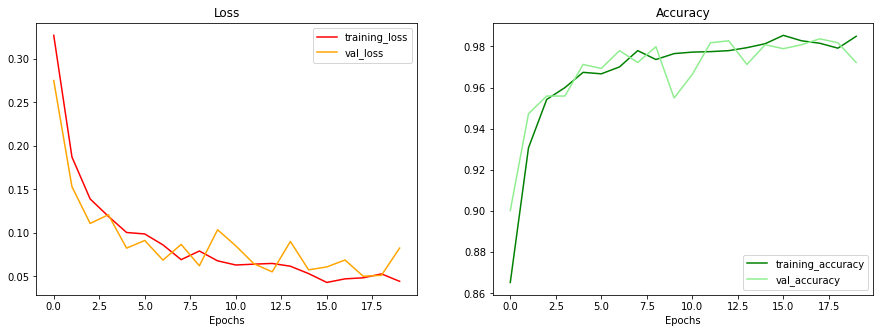

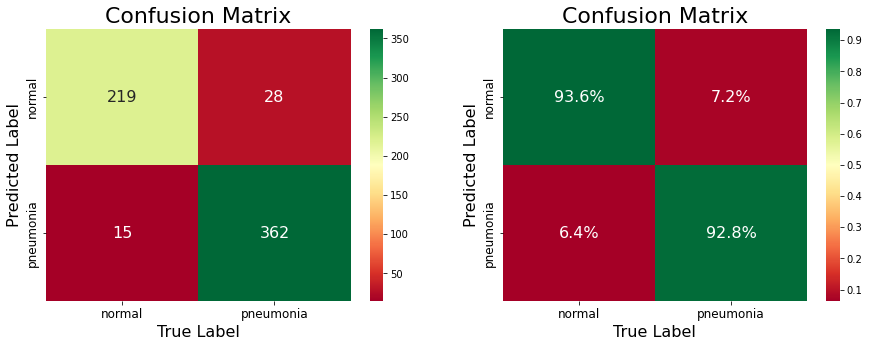

In [16]:
helpers.plot_loss_curves(history)

y_true, y_pred, metrics = helpers.evaluate_model_binary(
    binary_densenet_169, test_data)
print(metrics)

cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names)

In [12]:
base_model = tf.keras.applications.DenseNet201(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_densenet_201 = Model(inputs=inputs,
                            outputs=outputs,
                            name="binary_densenet_201")

binary_densenet_201.compile(loss='binary_crossentropy',
                            optimizer=optimizers.Adam(learning_rate=0.0001),
                            metrics=["accuracy"])

binary_densenet_201.summary()

history = binary_densenet_201.fit(train_data_augmented,
                                  epochs=2 * EPOCHS,
                                  validation_data=val_data_augmented,
                                  class_weight=binary_class_weight)

74850304/74836368 [==============================] - 1s 0us/step
Model: "binary_densenet_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 global_average_pooling_laye  (None, 1920)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 603,841
Non-trainable params: 17,720,064
_________________________________________________________________
Epoch 1/20


2022-05-04 06:58:35.849552: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-04 06:58:37.433196: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-05-04 06:58:37.446136: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


131/131 [==============================] - 81s 522ms/step - loss: 0.3411 - accuracy: 0.8639 - val_loss: 0.2520 - val_accuracy: 0.9195
Epoch 2/20
131/131 [==============================] - 56s 428ms/step - loss: 0.1890 - accuracy: 0.9365 - val_loss: 0.1857 - val_accuracy: 0.9358
Epoch 3/20
131/131 [==============================] - 55s 423ms/step - loss: 0.1385 - accuracy: 0.9542 - val_loss: 0.1274 - val_accuracy: 0.9626
Epoch 4/20
131/131 [==============================] - 55s 423ms/step - loss: 0.1119 - accuracy: 0.9660 - val_loss: 0.1095 - val_accuracy: 0.9578
Epoch 5/20
131/131 [==============================] - 56s 431ms/step - loss: 0.0970 - accuracy: 0.9662 - val_loss: 0.1239 - val_accuracy: 0.9578
Epoch 6/20
131/131 [==============================] - 56s 429ms/step - loss: 0.0972 - accuracy: 0.9693 - val_loss: 0.0916 - val_accuracy: 0.9664
Epoch 7/20
131/131 [==============================] - 57s 433ms/step - loss: 0.0858 - accuracy: 0.9708 - val_loss: 0.0997 - val_accuracy: 0.9

{'accuracy': 0.9455128205128205, 'precision': 0.9540816326530612, 'recall': 0.958974358974359, 'f1': 0.9565217391304348}


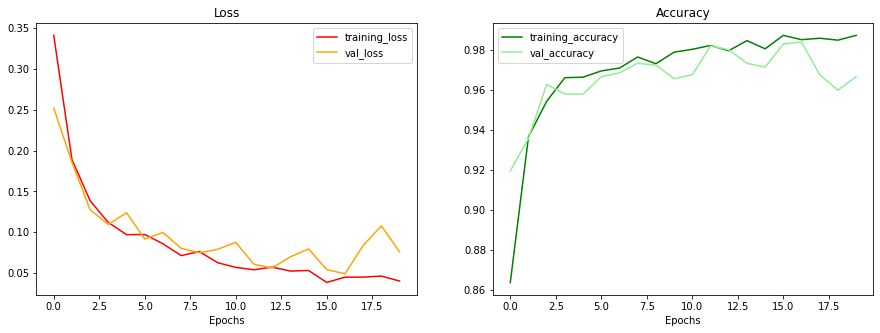

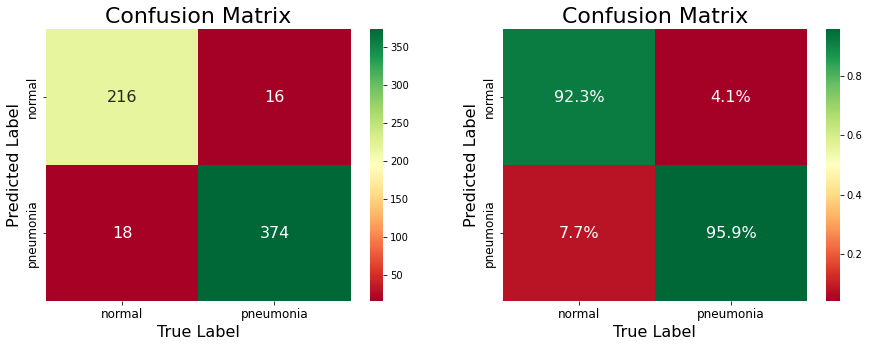

In [13]:
helpers.plot_loss_curves(history)

y_true, y_pred, metrics = helpers.evaluate_model_binary(
    binary_densenet_201, test_data)
print(metrics)

cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names)

In [21]:
base_model = tf.keras.applications.DenseNet201(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_densenet_201 = Model(inputs=inputs,
                            outputs=outputs,
                            name="binary_densenet_201")

binary_densenet_201.compile(loss='binary_crossentropy',
                            optimizer=optimizers.Adam(learning_rate=0.0001),
                            metrics=["accuracy"])

binary_densenet_201.summary()

history = binary_densenet_201.fit(train_data_augmented,
                                  epochs=3 * EPOCHS,
                                  validation_data=val_data_augmented,
                                  class_weight=binary_class_weight)

Model: "binary_densenet_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 global_average_pooling_laye  (None, 1920)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 603,841
Non-trainable params: 17,720,064
_________________________________________________________________
Epoch 1/30
131/131 [==============================] - 63s 438ms/step - loss: 0.3550 - accuracy:

{'accuracy': 0.9326923076923077, 'precision': 0.9142857142857143, 'recall': 0.9846153846153847, 'f1': 0.9481481481481482}


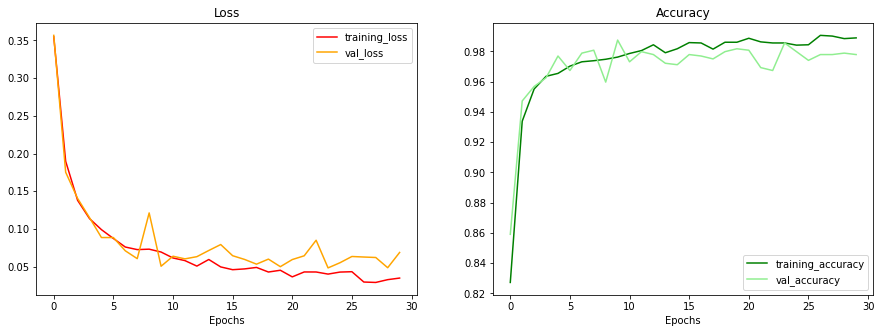

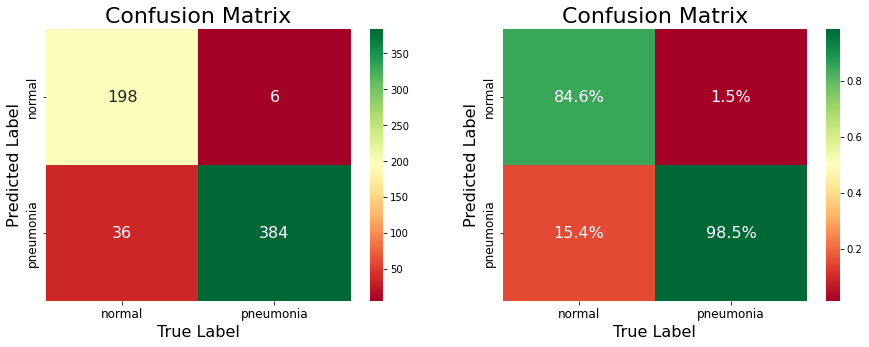

In [22]:
helpers.plot_loss_curves(history)

y_true, y_pred, metrics = helpers.evaluate_model_binary(
    binary_densenet_201, test_data)
print(metrics)

cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names)

In [ ]:
for score in [
        binary_evaluation_scores, binary_evaluation_scores_augmented,
        multi_evaluation_scores, multi_evaluation_scores_augmented
]:
    for _, _, metric in score:
        print(metric)
    print("\n")


{'accuracy': 0.625, 'precision': 0.625, 'recall': 1.0, 'f1': 0.7692307692307693}
{'accuracy': 0.7628205128205128, 'precision': 0.736328125, 'recall': 0.9666666666666667, 'f1': 0.8359201773835919}
{'accuracy': 0.7740384615384616, 'precision': 0.7408123791102514, 'recall': 0.982051282051282, 'f1': 0.844542447629548}


{'accuracy': 0.8044871794871795, 'precision': 0.79004329004329, 'recall': 0.9358974358974359, 'f1': 0.8568075117370892}
{'accuracy': 0.7676282051282052, 'precision': 0.7306967984934086, 'recall': 0.9948717948717949, 'f1': 0.8425624321389793}
{'accuracy': 0.625, 'precision': 0.625, 'recall': 1.0, 'f1': 0.7692307692307693}


{'accuracy': 0.38782051282051283, 'precision': 0.15040475016436555, 'recall': 0.38782051282051283, 'f1': 0.21674957067566766}
{'accuracy': 0.6153846153846154, 'precision': 0.6978032667730233, 'recall': 0.6153846153846154, 'f1': 0.592331390006908}
{'accuracy': 0.5192307692307693, 'precision': 0.637699881817529, 'recall': 0.5192307692307693, 'f1': 0.4562807

## Data resizing & augmentation

>🔑 **Note**: You can check the configuration of the data augmentation in `helpers.py`

In [ ]:
binary_train_data_augmented = helpers.preprocess_images(binary_train_data,
                                                        seed=SEED,
                                                        shuffle=True,
                                                        augment=True,
                                                        batch_size=BATCH_SIZE)
binary_val_data_augmented = helpers.preprocess_images(binary_val_data,
                                                      seed=SEED,
                                                      batch_size=BATCH_SIZE)
binary_test_data_augmented = helpers.preprocess_images(binary_test_data,
                                                       seed=SEED,
                                                       batch_size=BATCH_SIZE)

multi_train_data_augmented = helpers.preprocess_images(multi_train_data,
                                                       seed=SEED,
                                                       shuffle=True,
                                                       augment=True,
                                                       batch_size=BATCH_SIZE)
multi_val_data_augmented = helpers.preprocess_images(multi_val_data,
                                                     seed=SEED,
                                                     batch_size=BATCH_SIZE)
multi_test_data_augmented = helpers.preprocess_images(multi_test_data,
                                                      seed=SEED,
                                                      batch_size=BATCH_SIZE)


In [ ]:
binary_dense_model = models.load_model(
    'drive/MyDrive/tf_saved_models/binary_dense_model')
binary_tiny_vgg = models.load_model(
    'drive/MyDrive/tf_saved_models/binary_tiny_vgg')
binary_densenet_169 = models.load_model(
    'drive/MyDrive/tf_saved_models/binary_densenet_169')
binary_dense_model_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/binary_dense_model')
binary_tiny_vgg_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/binary_tiny_vgg')
binary_densenet_169_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/binary_densenet_169')

binary_models = [binary_dense_model, binary_tiny_vgg, binary_densenet_169]
binary_models_augmented = [
    binary_dense_model_augmented, binary_tiny_vgg_augmented,
    binary_densenet_169_augmented
]

multi_dense_model = models.load_model(
    'drive/MyDrive/tf_saved_models/multi_dense_model')
multi_tiny_vgg = models.load_model(
    'drive/MyDrive/tf_saved_models/multi_tiny_vgg')
multi_densenet_169 = models.load_model(
    'drive/MyDrive/tf_saved_models/multi_densenet_169')
multi_dense_model_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/multi_dense_model')
multi_tiny_vgg_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/multi_tiny_vgg')
multi_densenet_169_augmented = models.load_model(
    'drive/MyDrive/tf_saved_models/augmented_models/multi_densenet_169')

multi_models = [multi_dense_model, multi_tiny_vgg, multi_densenet_169]
multi_models_augmented = [
    multi_dense_model_augmented, multi_tiny_vgg_augmented,
    multi_densenet_169_augmented
]


In [ ]:
# y_pred = binary_dense_model.predict(binary_test_data)
# y_pred = np.round(y_pred.flatten())
# labels = np.concatenate([np.ravel(y.numpy()) for _, y in binary_test_data])

# acc = accuracy_score(labels, y_pred)
# pre = precision_score(labels, y_pred)
# rec = recall_score(labels, y_pred)
# f1 = f1_score(labels, y_pred)

In [ ]:
# fig = plt.figure(figsize=(16, 8))
# x = [float(f"{v:.2}") for v in [acc, pre, rec, f1]]
# hist = sns.barplot(x=np.array(x), y=np.array(["accuracy", "precision", "recall", "f1"]), palette="YlOrBr");
# hist.bar_label(hist.containers[0], padding=-40)
# hist.set_frame_on(False)